- **Long Short Term Memory Networks**
  - A form of recurrent neural network architecture.
  - To overcome the drawbacks of RNNs. LSTMs introduce the idea of a "cell".
  - This cell has an intricate structural design that allows it to selectively recall or forget specific information.
  - The efficacy of LSTMs relied on their ability to update, forget and retain
- **LSTM cell consists of following componenets:**
  - Cells: The memory units of LSTMs.
  - Foget Gate: Decides which information from the previous cell state to discard.
  - Input Gate: Determines which new info from the current input to remember.
  - Output Gate: Controls what information from the current cell state to expose as the output 

In [12]:
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 

In [13]:
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Generate synthetic sine wave data
t = np.linspace(0, 100, 1000)
data = np.sin(t)

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data, seq_length)

# Convert data to PyTorch tensors
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [14]:
# LSTM Model 
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        batch_size = x.size(0)
        
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [15]:
# Initialize model, loss and optimizer 
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
num_epochs = 100
batch_size = trainX.size(0)  # Using full batch for this example
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs, h0, c0 = model(trainX, h0, c0)
    
    # Compute loss
    loss = criterion(outputs, trainY)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    # Detach hidden and cell states
    h0 = h0.detach()
    c0 = c0.detach()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.2866
Epoch [20/100], Loss: 0.0900
Epoch [30/100], Loss: 0.0379
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0027
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


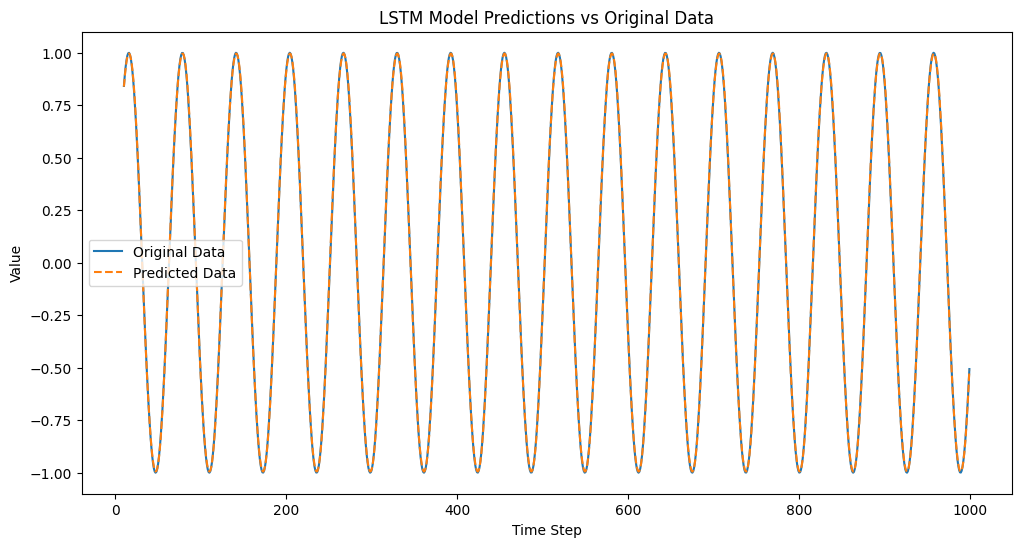

In [17]:
# Predicted outputs 
model.eval()
predicted, _, _ = model(trainX, h0, c0)

# Adjusting the original data and prediction for plotting 
original = data[seq_length:]
time_steps = np.arange(seq_length, len(data))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs Original Data')
plt.xlabel("Time Step")
plt.ylabel('Value')
plt.legend()
plt.show()